<img src="earth_engine1.png" alt="earth_engine1" width="800" height="600"/>

<img src="earth_engine2.png" alt="earth_engine2" width="800" height="600"/>

<img src="earth_engine3.png" alt="earth_engine3" width="800" height="600"/>

In [1]:
# -*- coding: utf-8 -*-
"""Análisis de la Ciénaga de Mallorquín con Sentinel-2 - GeoJSON de ArcGIS"""

# Importar librerías
import ee
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
import datetime
import sys
import time
import json
import os

# Configuración de matplotlib para español
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Autenticar e inicializar Earth Engine
try:
    ee.Initialize()
    print("Earth Engine inicializado correctamente")
except Exception as e:
    print("Autenticando Earth Engine...")
    ee.Authenticate()
    ee.Initialize()

# ------------------------------------------------------------
# FUNCIÓN SIMPLIFICADA PARA CARGAR GEOJSON
# ------------------------------------------------------------
def load_arcgis_geojson_simple(filename):
    """Carga GeoJSON de forma simplificada y robusta"""
    try:
        if not os.path.exists(filename):
            print(f"Archivo {filename} no encontrado. Usando geometría por defecto.")
            return ee.Geometry.Polygon([
                [[-74.812, 11.018], [-74.812, 11.028], [-74.798, 11.028], [-74.798, 11.018], [-74.812, 11.018]]
            ])
        
        with open(filename, 'r', encoding='utf-8') as f:
            geojson_data = json.load(f)
        
        print("GeoJSON cargado correctamente (versión simple)")
        
        # Cargar directamente como geometría
        geometry = ee.Geometry(geojson_data)
        
        # Información básica
        area_km2 = geometry.area().getInfo() / 1e6
        print(f"Área: {area_km2:.3f} km²")
        print(f"Tipo: {geometry.type().getInfo()}")
        
        return geometry
        
    except Exception as e:
        print(f"Error cargando GeoJSON: {e}")
        return ee.Geometry.Polygon([
            [[-74.812, 11.018], [-74.812, 11.028], [-74.798, 11.028], [-74.798, 11.018], [-74.812, 11.018]]
        ])

# ------------------------------------------------------------
# FUNCIÓN MEJORADA PARA CARGAR GEOJSON DE ARCGIS
# ------------------------------------------------------------
def load_arcgis_geojson(filename):
    """
    Carga y procesa GeoJSON desde ArcGIS, especialmente para la Ciénaga de Mallorquín.
    Detecta si el archivo trae varias features y genera la geometría adecuada.
    """
    try:
        if not os.path.exists(filename):
            print(f"Archivo {filename} no encontrado. Usando geometría por defecto.")
            return ee.Geometry.Polygon([
                [[-74.812, 11.018], [-74.812, 11.028],
                 [-74.798, 11.028], [-74.798, 11.018],
                 [-74.812, 11.018]]
            ])
        
        with open(filename, 'r', encoding='utf-8') as f:
            geojson_data = json.load(f)
        
        print("Estructura del GeoJSON:")
        print(f"Tipo: {geojson_data.get('type', 'Desconocido')}")
        
        # Caso 1: GeoJSON con múltiples features
        if 'features' in geojson_data:
            print(f"Número de features: {len(geojson_data['features'])}")
            feature_collection = ee.FeatureCollection(geojson_data["features"])
            geometry = feature_collection.geometry()
            print(f"Geometría tipo: {geometry.type().getInfo()}")
        
        # Caso 2: GeoJSON con una sola feature
        elif 'geometry' in geojson_data:
            geometry = ee.Geometry(geojson_data['geometry'])
            print("Cargado como Geometry individual")
        
        # Caso 3: GeoJSON que es directamente una geometría
        else:
            geometry = ee.Geometry(geojson_data)
            print("Cargado como Geometry directa")
        
        # Información básica
        area_m2 = geometry.area().getInfo()
        area_km2 = area_m2 / 1e6
        bounds = geometry.bounds().getInfo()
        
        print(f"Área de la geometría: {area_km2:.3f} km²")
        print(f"Límites: {bounds}")
        
        return geometry
    
    except Exception as e:
        print(f"Error procesando GeoJSON: {e}")
        print("Usando geometría por defecto para Ciénaga de Mallorquín...")
        return ee.Geometry.Polygon([
            [[-74.812, 11.018], [-74.812, 11.028],
             [-74.798, 11.028], [-74.798, 11.018],
             [-74.812, 11.018]]
        ])

# ------------------------------------------------------------
# CARGAR LA GEOMETRÍA
# ------------------------------------------------------------
print("Cargando geometría desde GeoJSON de ArcGIS...")
cienaga_mallorquin = load_arcgis_geojson("mallorquin.geojson")

# ------------------------------------------------------------
# FUNCIONES DE MÁSCARA DE NUBES
# ------------------------------------------------------------
def mask_s2_sr_clouds(image):
    """Máscara simple usando clases SCL"""
    scl = image.select('SCL')
    mask = (scl.eq(6)   # water
            .Or(scl.eq(4))  # vegetation
            .Or(scl.eq(5))  # bare soil
            .Or(scl.eq(7))) # unclassified
    return image.updateMask(mask).copyProperties(image, ["system:time_start"])

def mask_s2_cloudprob(image, prob_threshold=20):
    """Máscara usando probabilidad de nubes"""
    cloud_prob = image.select('MSK_CLDPRB')
    mask = cloud_prob.lt(prob_threshold)
    return image.updateMask(mask).copyProperties(image, ["system:time_start"])

def mask_s2_sr_clouds_hybrid(image, prob_threshold=20):
    """Máscara híbrida combinando SCL y probabilidad de nubes"""
    scl = image.select('SCL')
    cloud_prob = image.select('MSK_CLDPRB')
    mask = (cloud_prob.lt(prob_threshold)
            .And(scl.neq(3))
            .And(scl.neq(8))
            .And(scl.neq(9))
            .And(scl.neq(10)))
    return image.updateMask(mask).copyProperties(image, ["system:time_start"])

# ------------------------------------------------------------
# FUNCIÓN PRINCIPAL PARA SENTINEL-2
# ------------------------------------------------------------
def get_sentinel2_data(geometry, start_date, end_date, cloud_filter=50, mask_type="hybrid"):
    """Obtiene imágenes Sentinel-2 con diferentes opciones de máscara"""
    collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                  .filterBounds(geometry)
                  .filterDate(start_date, end_date)
                  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', cloud_filter)))
    
    if mask_type == "scl":
        collection = collection.map(mask_s2_sr_clouds)
    elif mask_type == "cloudprob":
        collection = collection.map(mask_s2_cloudprob)
    else:
        collection = collection.map(mask_s2_sr_clouds_hybrid)
    
    return collection.sort('system:time_start', False)

# ------------------------------------------------------------
# CREAR MOSAICO LIBRE DE NUBES
# ------------------------------------------------------------
def get_cloud_free_composite(geometry, start_date, end_date, mask_type="hybrid"):
    """Crea un composite libre de nubes usando varias imágenes Sentinel-2"""
    collection = get_sentinel2_data(geometry, start_date, end_date, mask_type=mask_type)
    
    # Normalizar reflectancia
    collection = collection.map(lambda img: img.divide(10000.0))
    
    # Usar mediana para eliminar nubes
    composite = collection.median()
    
    return composite

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_7TDKVSyKvBdmMqW?ref=4i2o6


Earth Engine inicializado correctamente
Cargando geometría desde GeoJSON de ArcGIS...
Estructura del GeoJSON:
Tipo: FeatureCollection
Número de features: 1
Geometría tipo: MultiPolygon
Área de la geometría: 7.128 km²
Límites: {'geodesic': False, 'type': 'Polygon', 'coordinates': [[[-74.86786873025318, 11.031862530123732], [-74.83037033897318, 11.031862530123732], [-74.83037033897318, 11.060412160567207], [-74.86786873025318, 11.060412160567207], [-74.86786873025318, 11.031862530123732]]]}


Número de imágenes disponibles: 73
Procesando imágenes...
Procesando 1/30 - 2024-06-29
Procesando 2/30 - 2024-05-20
Procesando 3/30 - 2024-04-30
Procesando 4/30 - 2024-04-20
Procesando 5/30 - 2024-04-15
Procesando 6/30 - 2024-04-10
Procesando 7/30 - 2024-03-31
Procesando 8/30 - 2024-03-26
Procesando 9/30 - 2024-03-16
Procesando 10/30 - 2024-03-11
Procesando 11/30 - 2024-03-06
Procesando 12/30 - 2024-03-01
Procesando 13/30 - 2024-02-25
Procesando 14/30 - 2024-02-20
Procesando 15/30 - 2024-02-15
Procesando 16/30 - 2024-02-10
Procesando 17/30 - 2024-02-05
Procesando 18/30 - 2024-01-31
Procesando 19/30 - 2024-01-26
Procesando 20/30 - 2024-01-21
Procesando 21/30 - 2024-01-16
Procesando 22/30 - 2024-01-11
Procesando 23/30 - 2024-01-06
Procesando 24/30 - 2024-01-01
Procesando 25/30 - 2023-12-17
Procesando 26/30 - 2023-12-12
Procesando 27/30 - 2023-12-07
Procesando 28/30 - 2023-12-02
Procesando 29/30 - 2023-11-27
Procesando 30/30 - 2023-11-17

Datos procesados:
                NDWI  Turbidity 

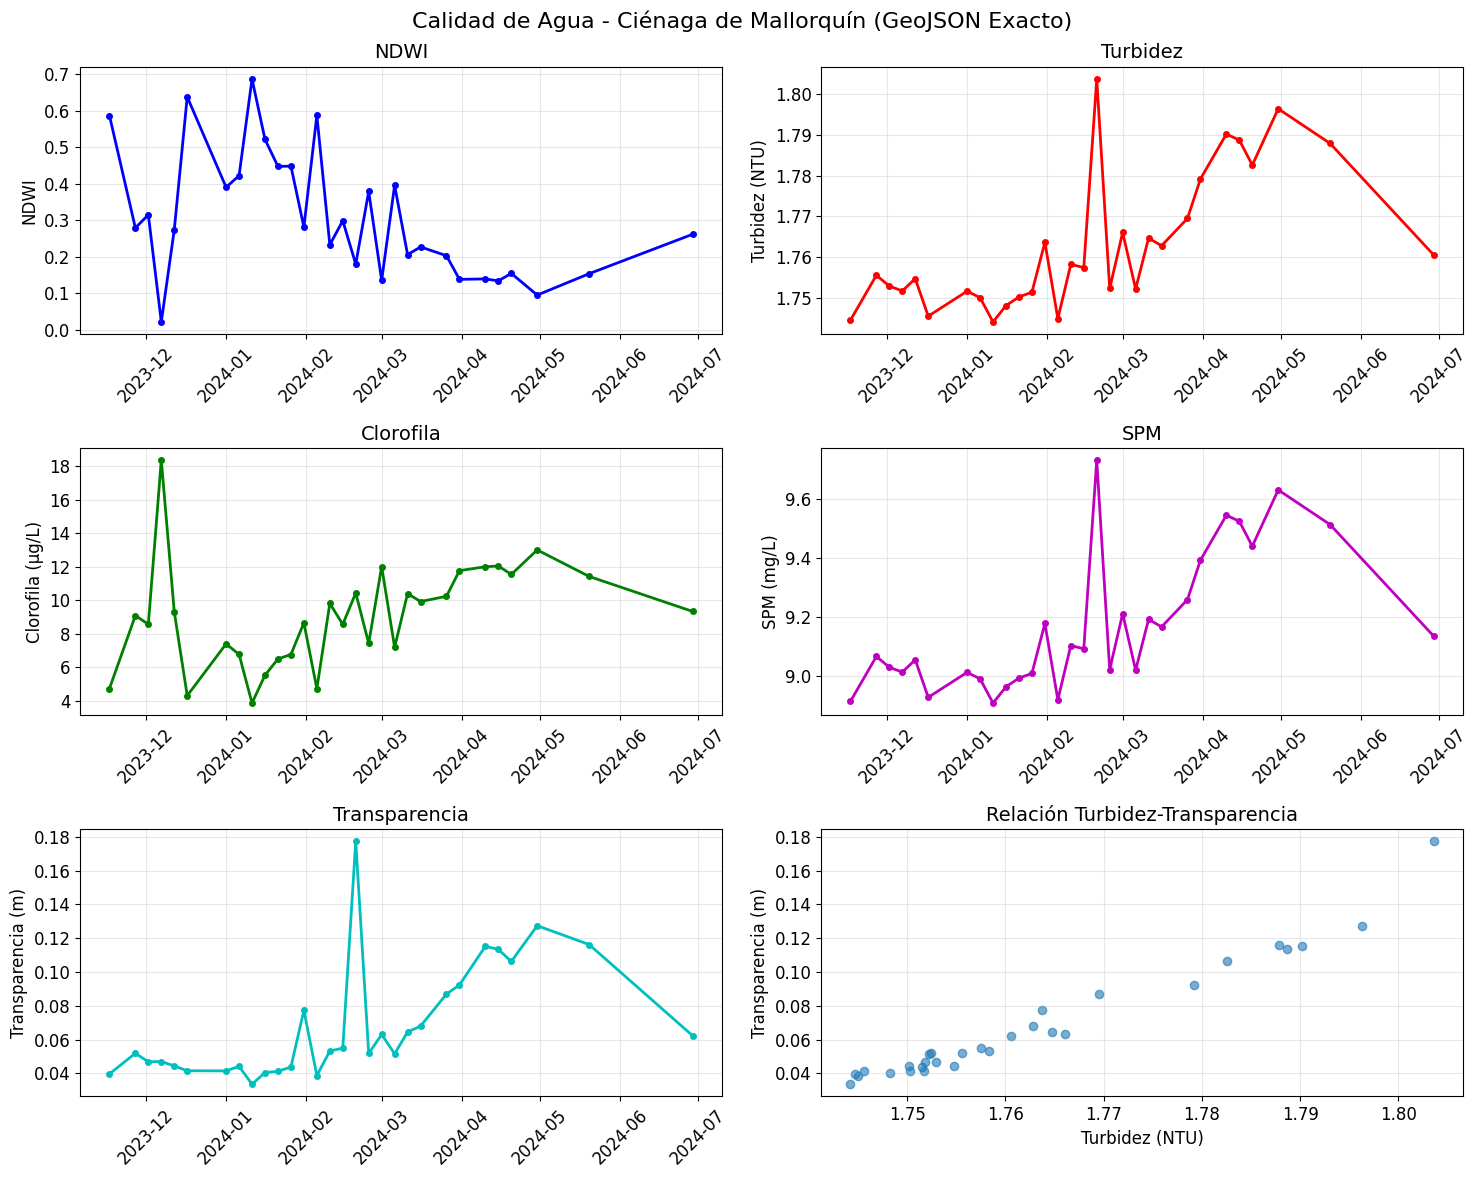

Datos exportados a cienaga_mallorquin_exacta.csv
Generando mosaico libre de nubes...


Map(center=[11.044362659333155, -74.84867395546866], controls=(WidgetControl(options=['position', 'transparent…


ANÁLISIS COMPLETADO


In [2]:
# ------------------------------------------------------------
# ANÁLISIS PRINCIPAL
# ------------------------------------------------------------
# Fechas de análisis
start_date = '2023-01-01'
end_date = '2024-06-30'

# Obtener colección de imágenes en rango
collection = get_sentinel2_data(cienaga_mallorquin, start_date, end_date)

# Verificar número de imágenes
num_images = collection.size().getInfo()
print(f'Número de imágenes disponibles: {num_images}')

if num_images > 0:
    # Procesar imágenes
    print("Procesando imágenes...")
    
    time_series_data = []
    image_list = collection.toList(collection.size())
    max_images_to_process = min(num_images, 30)
    
    for i in range(max_images_to_process):
        try:
            image = ee.Image(image_list.get(i))
            date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd').getInfo()
            
            print(f"Procesando {i+1}/{max_images_to_process} - {date}")
            
            # Normalizar y calcular parámetros
            img = image.divide(10000.0)
            
            # Parámetros de calidad de agua
            ndwi = img.normalizedDifference(['B3', 'B8']).rename('NDWI')
            turbidity = img.select('B4').multiply(0.39).add(1.73).rename('Turbidity')
            chlorophyll = img.select('B8').divide(img.select('B3')).multiply(15).rename('Chlorophyll')
            spm = img.select('B4').multiply(5.42).add(8.71).rename('SPM')
            transparency = img.select('B2').add(img.select('B3')).divide(2).multiply(0.8).rename('Transparency')
            
            # Imagen resultante
            result_image = ee.Image.cat([ndwi, turbidity, chlorophyll, spm, transparency])
            
            # Extraer estadísticas
            stats_dict = {'date': date}
            parameters = ['NDWI', 'Turbidity', 'Chlorophyll', 'SPM', 'Transparency']
            
            for param in parameters:
                try:
                    stat = result_image.select(param).reduceRegion(
                        reducer=ee.Reducer.mean(),
                        geometry=cienaga_mallorquin,
                        scale=30,
                        maxPixels=1e9
                    ).getInfo()
                    stats_dict[param] = stat.get(param, np.nan)
                except Exception as e:
                    print(f"Error obteniendo {param}: {e}")
                    stats_dict[param] = np.nan
            
            time_series_data.append(stats_dict)
            
        except Exception as e:
            print(f"Error en imagen {i+1}: {e}")
            continue
    
    # Crear DataFrame y mostrar resultados
    if time_series_data:
        df_water_quality = pd.DataFrame(time_series_data)
        df_water_quality['date'] = pd.to_datetime(df_water_quality['date'])
        df_water_quality.set_index('date', inplace=True)
        
        print("\nDatos procesados:")
        print(df_water_quality.head())
        
        # Visualización
        def plot_results(df):
            fig, axes = plt.subplots(3, 2, figsize=(15, 12))
            fig.suptitle('Calidad de Agua - Ciénaga de Mallorquín (GeoJSON Exacto)', fontsize=16)
            
            plots_config = [
                ('NDWI', 'NDWI', 'b-', axes[0,0]),
                ('Turbidity', 'Turbidez (NTU)', 'r-', axes[0,1]),
                ('Chlorophyll', 'Clorofila (μg/L)', 'g-', axes[1,0]),
                ('SPM', 'SPM (mg/L)', 'm-', axes[1,1]),
                ('Transparency', 'Transparencia (m)', 'c-', axes[2,0])
            ]
            
            for col, ylabel, style, ax in plots_config:
                if col in df.columns:
                    ax.plot(df.index, df[col], style, linewidth=2, marker='o', markersize=4)
                    ax.set_title(ylabel.split(' (')[0])
                    ax.set_ylabel(ylabel)
                    ax.grid(True, alpha=0.3)
                    ax.tick_params(axis='x', rotation=45)
            
            # Scatter plot
            if 'Turbidity' in df.columns and 'Transparency' in df.columns:
                axes[2,1].scatter(df['Turbidity'], df['Transparency'], alpha=0.6)
                axes[2,1].set_title('Relación Turbidez-Transparencia')
                axes[2,1].set_xlabel('Turbidez (NTU)')
                axes[2,1].set_ylabel('Transparencia (m)')
                axes[2,1].grid(True, alpha=0.3)
            else:
                axes[2,1].set_visible(False)
            
            plt.tight_layout()
            plt.show()
        
        plot_results(df_water_quality)
        
        # Exportar resultados
        csv_filename = "cienaga_mallorquin_exacta.csv"
        df_water_quality.to_csv(csv_filename)
        print(f"Datos exportados a {csv_filename}")
        
        # ========================================================
        # MOSTRAR SOLO EL MOSAICO LIBRE DE NUBES
        # ========================================================
        print("Generando mosaico libre de nubes...")
        try:
            composite_image = get_cloud_free_composite(cienaga_mallorquin, start_date, end_date)

            Map = geemap.Map()
            Map.centerObject(cienaga_mallorquin, 13)

            # Añadir RGB limpio
            Map.addLayer(composite_image.select(['B4','B3','B2']), 
                         {'min':0, 'max':0.3}, 
                         'RGB libre de nubes')

            # Añadir la geometría en rojo
            Map.addLayer(cienaga_mallorquin, 
                         {'color': 'red', 'fillColor': '00000000', 'width': 3}, 
                         'Límites Ciénaga')

            Map.addLayerControl()
            display(Map)

        except Exception as e:
            print(f"Error generando composite libre de nubes: {e}")

    else:
        print("No se pudieron procesar datos")

else:
    print("No hay imágenes disponibles. Probando con más nubes permitidas...")
    collection = get_sentinel2_data(cienaga_mallorquin, start_date, end_date, cloud_filter=80)
    num_images = collection.size().getInfo()
    print(f'Imágenes con 80% nubes: {num_images}')

print("\n" + "="*60)
print("ANÁLISIS COMPLETADO")
print("="*60)